# <font color='red'> Identifying similar neighborhood clusters  </font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import requests
import json
import pyarrow as pa
from pyarrow import csv
from functools import reduce

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
key = '5a59dc391d04d6d14c7d339b10f641e96d90e24c'

# <font color='blue'> Loading housing and census data</font>

## <font color='green'> Loading Zillow data set with zip code level census data</font>

In [4]:
# loading Zillow data
temp_zillow_df = pd.read_csv('assets/master_v3.csv')
#temp_zillow_df.head(5)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
temp_zillow_df.head(1)

RegionID  SizeRank  RegionName RegionType StateName State  City  \
0     91982         1       77494        zip        TX    TX  Katy   

                                  Metro        CountyName     2017-01-31  \
0  Houston-The Woodlands-Sugar Land, TX  Fort Bend County  323580.258551   

    2017-02-28     2017-03-31     2017-04-30     2017-05-31     2017-06-30  \
0  322859.2963  322172.727476  322516.749622  322978.926793  323205.955231   

      2017-07-31     2017-08-31     2017-09-30     2017-10-31     2017-11-30  \
0  322779.711142  322513.207467  322682.219797  323191.687596  323615.150445   

      2017-12-31     2018-01-31   2018-02-28     2018-03-31     2018-04-30  \
0  324133.825095  324431.610354  324518.3054  324904.351333  325574.598813   

      2018-05-31     2018-06-30    2018-07-31     2018-08-31     2018-09-30  \
0  326721.789199  327378.315997  327962.38602  328151.314955  328488.992137   

      2018-10-31     2018-11-30     2018-12-31     2019-01-31     2019-02-28  \
0  328445.181025  328527.596313  328606.237787  328965.647984  329580.667244   

      2019-03-31     2019-04-30     2019-05-31     2019-06-30     2019-07-31  \
0  330194.170015  330761.725678  330993.312868  330928.352876  330579.816984   

      2019-08-31     2019-09-30     2019-10-31     2019-11-30     2019-12-31  \
0  330071.617802  329960.101551  330148.248602  330784.223757  331640.578737   

     2020-01-31     2020-02-29    2020-03-31     2020-04-30    2020-05-31  \
0  332850.01797  334098.248569  335108.16127  335570.000946  335469.25392   

      2020-06-30     2020-07-31     2020-08-31     2020-09-30     2020-10-31  \
0  335168.785598  335226.368509  336150.072867  338143.641748  340955.056939   

      2020-11-30    2020-12-31     2021-01-31     2021-02-28     2021-03-31  \
0  344610.598885  348663.66144  353194.128413  358263.737167  364177.203091   

     2021-04-30     2021-05-31     2021-06-30     2021-07-31     2021-08-31  \
0  371101.69109  378932.346656  387075.484534  394738.155396  401313.529878   

     2021-09-30     2021-10-31    2021-11-30     2021-12-31    2022-01-31  \
0  406753.63953  411963.818455  417782.69854  423914.215432  431341.96535   

      2022-02-28     2022-03-31     2022-04-30    2022-05-31     2022-06-30  \
0  439850.093053  450557.076193  462381.617356  474375.95061  484860.856848   

      2022-07-31     2022-08-31     2022-09-30     2022-10-31     2022-11-30  \
0  491097.166274  492342.040046  490010.723778  487050.633082  484812.248823   

      2022-12-31     2023-01-31     2023-02-28    2023-03-31     2023-04-30  \
0  483270.636456  481038.183265  479721.873619  478668.36715  479881.403656   

      2023-05-31     2023-06-30    2023-07-31     2023-08-31  B01001_001E  \
0  481894.597228  485046.382049  487872.99138  490385.169211       129165   

   B01001_002E  B01001_026E  B01002_001E  B01002_002E  B01002_003E  \
0        62933        66232         36.9         37.3         36.6   

   B08012_002E  B08012_003E  B08012_004E  B08012_005E  B08012_006E  \
0        612.0       2419.0       3272.0       4541.0       3931.0   

   B08012_007E  B08012_008E  B08012_009E  B08012_010E  B08012_011E  \
0       2877.0       6628.0       1391.0       4018.0       8890.0   

   B08012_012E  B08012_013E  B17026_002E  B17026_003E  B17026_004E  \
0       6336.0       1080.0       1025.0        104.0        343.0   

   B17026_005E  B17026_006E  B17026_007E  B17026_008E  B17026_009E  \
0        797.0        546.0        532.0        283.0        904.0   

   B17026_010E  B17026_011E  B17026_012E  B17026_013E  \
0       1333.0       3265.0       5498.0      20436.0   

   zip code tabulation area  year  state_x  __index_level_0__  state_y  \
0                     77494  2021      NaN                  0      NaN   

   house_occupied_ratio  house_vacant_ratio  \
0              0.959002            0.040998   

   has_one_or_more_computing_device_ratio  has_no_computing_device_ratio  \
0                            

## <font color='green'> Loading Census data at county level </font>

In [7]:
def get_census_data_by_zip(api_key, fields, year):
    """
    Fetch census data by ZIP Code Tabulation Areas (ZCTAs) for specified fields.
    
    :param api_key: Your Census API Key.
    :param fields: List of fields to fetch.
    :param year: Census year (default is 2020).
    :return: DataFrame with fetched data.
    """
    base_url = f"https://api.census.gov/data/{year}/acs/acs5"
    
    # Combine the fields into a comma-separated string
    fields_str = ",".join(fields)

    # Construct the final URL
    url = f"{base_url}?get={fields_str}&for=county:*"
    
    headers = {
        "Content-Type": "application/json",
    }

    # Make the API request
    response = requests.get(url, headers=headers, params={"key": api_key})
    
    if response.status_code == 200:
        data = response.json()
        # Convert data to DataFrame
        df = pd.DataFrame(data[1:], columns=data[0])
        df['year'] = year
        return df
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [8]:
fields_set1 = list(['B07401_001E', 'B07401_002E', 'B07401_003E', 'B07401_004E', 'B07401_005E', 'B07401_006E', 'B07401_007E',\
                'B07401_008E','B07401_009E','B07401_010E','B07401_011E','B07401_012E','B07401_013E','B07401_014E','B07401_015E',\
                'B07401_016E', 'B25034_001E', 'B25034_002E', 'B25034_003E', 'B25034_004E', 'B25034_005E', 'B25034_006E',\
                'B25034_007E', 'B25034_008E', 'B25034_009E', 'B25034_010E', 'B25034_011E', 'B25017_001E', 'B25017_002E'])

fields_set2 = list(['B25017_003E', 'B25017_004E', 'B25017_005E', 'B25017_006E', 'B25017_007E', 'B25017_008E', 'B25017_009E',\
                'B25017_010E', 'B25024_001E', 'B25024_002E', 'B25024_003E', 'B25024_004E', 'B25024_005E', 'B25024_006E',\
                'B25024_007E', 'B25024_008E', 'B25024_009E', 'B25024_010E', 'B25024_011E', 'B11001_001E', 'B11001_002E',\
                'B11001_003E', 'B11001_004E', 'B11001_005E', 'B11001_006E', 'B11001_007E', 'B11001_008E', 'B11001_009E',\
                'B25004_001E', 'B25004_002E', 'B25004_003E', 'B25004_004E', 'B25004_005E', 'B25004_006E', 'B25004_007E',\
                'B25004_008E', 'B25010_001E', 'B25010_002E', 'B25010_003E'])

df1 = get_census_data_by_zip(key, fields_set1, 2021)
df2 = get_census_data_by_zip(key, fields_set1, 2020)
df3 = get_census_data_by_zip(key, fields_set1, 2019)
df4 = get_census_data_by_zip(key, fields_set1, 2018)

df5 = get_census_data_by_zip(key, fields_set2, 2021)
df6 = get_census_data_by_zip(key, fields_set2, 2020)
df7 = get_census_data_by_zip(key, fields_set2, 2019)
df8 = get_census_data_by_zip(key, fields_set2, 2018)

In [9]:
temp_f1 = [df1, df2, df3, df4]
field_set1 = pd.concat(temp_f1)
temp_f2 = [df5, df6, df7, df8]
field_set2 = pd.concat(temp_f2)

In [10]:
#merge all DataFrames into one
additional_features_df = pd.merge(field_set1, field_set2, on=['state','county','year'], how='left')

In [11]:
additional_features_df['temp_fips_code'] = additional_features_df['state'].astype('str') + additional_features_df['county'].astype('str')

In [12]:
additional_features_df['fips_code'] = additional_features_df['temp_fips_code'].apply(lambda x: '0'+str(x) if len(str(x))==4 else x)

In [13]:
additional_features_df.head(5)

B07401_001E B07401_002E B07401_003E B07401_004E B07401_005E B07401_006E  \
0       60383        2947       10992        1581        3844        4139   
1      222200       10054       36846        5321       11054       12419   
2       25001        1251        3833         664        1375        1760   
3       21546         981        3446         551        1237        1825   
4       57931        2867       10296        1425        3195        3618   

  B07401_007E B07401_008E B07401_009E B07401_010E B07401_011E B07401_012E  \
0        4025        4448        3806        4190        3919        4407   
1       12198       14571       13129       14328       14361       15666   
2        1803        1731        1457        1531        1554        1601   
3        1099        1554        1501        1597        1389        1424   
4        3488        3135        3921        3859        3844        3959   

  B07401_013E B07401_014E B07401_015E B07401_016E B25034_001E B25034_002E  \
0        3378        2645        2630        3432       24170          71   
1       16527       13921       13773       18032      121763         441   
2        1746        1478        1319        1898       11667           0   
3        1396        1152         885        1509        9013           0   
4        3902        3305        2847        4270       24527          22   

  B25034_003E B25034_004E B25034_005E B25034_006E B25034_007E B25034_008E  \
0        2448        5225        5219        2378        4314        2826   
1       16439       33130       28609       18606       10981        6222   
2         430        1091        2551        1918        1751        1457   
3         619        1337        1837        1446        1413         997   
4        1352        4763        5545        3508        3645        2300   

  B25034_009E B25034_010E B25034_011E B25017_001E B25017_002E state county  \
0         860         327         502       24170         169    01    001   
1        2909        1721        2705      121763        1546    01    003   
2        1000         580         889       11667          41    01    005   
3         448         268         648        9013          79    01    007   
4        1173         974        1245       24527         178    01    009   

   year B25017_003E B25017_004E B25017_005E B25017_006E B25017_007E  \
0  2021         236        1167        2784        4643        5692   
1  2021        1457        6065       18355       26242       26432   
2  2021         243        1371        1946        2732        2251   
3  2021         132         290        1323        2234        2177   
4  2021         232         838        3164        6030        5327   

  B25017_008E B25017_009E B25017_010E B25024_001E B25024_002E B25024_003E  \
0        3857        2524        3098       24170       17691         299   
1       16291       11888       13487      121763       78401        1572   
2        1421         698         964       11667        6381         116   
3        1288         631         859        9013        5536          29   
4        3280        2381        3097       24527       16932         236   

  B25024_004E B25024_005E B25024_006E B25024_007E B25024_008E B25024_009E  \
0          53         400         553         396         287         291   
1        1951        2383        3901        4372        2511       14074   
2         785         493         228          54          42          56   
3          61          27         231          57          19          86   
4         410         378         256          73         132           1   

  B25024_010E B25024_011E B11001_001E B11001_002E B11001_003E B11001_004E  \
0        4112          88       21856       15321       11465        3856   
1       12215         383       87190       58062       47986       10076   
2        3500          12        9088        5860        3423        2437   
3        2872       

# <font color='blue'> Cleaning data set and descriptive statistics </font>

In [16]:
# Get all the column names used to pivot the data 
column_names = temp_zillow_df.columns

column_names_ids = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName',\
                    'B01001_001E', 'B01001_002E', 'B01001_026E', 'B01002_001E', 'B01002_002E', 'B01002_003E', 'B08012_002E', \
                    'B08012_003E', 'B08012_004E', 'B08012_005E', 'B08012_006E', 'B08012_007E', 'B08012_008E', 'B08012_009E',\
                    'B08012_010E', 'B08012_011E', 'B08012_012E', 'B08012_013E', 'B17026_002E', 'B17026_003E', 'B17026_004E',\
                    'B17026_005E', 'B17026_006E', 'B17026_007E', 'B17026_008E', 'B17026_009E', 'B17026_010E', 'B17026_011E',\
                    'B17026_012E', 'B17026_013E', 'year', 'house_occupied_ratio','house_vacant_ratio',\
                    'has_one_or_more_computing_device_ratio', 'has_no_computing_device_ratio','has_health_insurance_ratio',\
                    'has_health_insurance_ratio_26_to_64','has_health_insurance_ratio_65_and_over']

column_names_values = list(set(column_names).difference(column_names_ids))

# Melt the dataframe 
zillow_df = temp_zillow_df.melt(id_vars=column_names_ids,
                                var_name='date',
                                value_vars=column_names_values,
                                value_name='sale_price')

In [17]:
zillow_df['year_to_filter'] = zillow_df['date'].apply(lambda x: str(x).split('-',1)[0])

In [18]:
#len(zillow_df)

In [19]:
#zillow_df['year'].unique()

In [20]:
#zillow_df['year_to_filter'].unique()

In [21]:
zillow_df['year'] = zillow_df['year'].astype('str')
zillow_df['year_to_filter'] = zillow_df['year_to_filter'].astype('str', errors = 'ignore')

In [22]:
zillow_df.head(1)

RegionID  SizeRank  RegionName RegionType StateName State  City  \
0     91982         1       77494        zip        TX    TX  Katy   

                                  Metro        CountyName  B01001_001E  \
0  Houston-The Woodlands-Sugar Land, TX  Fort Bend County       129165   

   B01001_002E  B01001_026E  B01002_001E  B01002_002E  B01002_003E  \
0        62933        66232         36.9         37.3         36.6   

   B08012_002E  B08012_003E  B08012_004E  B08012_005E  B08012_006E  \
0        612.0       2419.0       3272.0       4541.0       3931.0   

   B08012_007E  B08012_008E  B08012_009E  B08012_010E  B08012_011E  \
0       2877.0       6628.0       1391.0       4018.0       8890.0   

   B08012_012E  B08012_013E  B17026_002E  B17026_003E  B17026_004E  \
0       6336.0       1080.0       1025.0        104.0        343.0   

   B17026_005E  B17026_006E  B17026_007E  B17026_008E  B17026_009E  \
0        797.0        546.0        532.0        283.0        904.0   

   B17026_010E  B17026_011E  B17026_012E  B17026_013E  year  \
0       1333.0       3265.0       5498.0      20436.0  2021   

   house_occupied_ratio  house_vacant_ratio  \
0              0.959002            0.040998   

   has_one_or_more_computing_device_ratio  has_no_computing_device_ratio  \
0                                0.991112                       0.008888   

   has_health_insurance_ratio  has_health_insurance_ratio_26_to_64  \
0                    0.926645                             0.925834   

   has_health_insurance_ratio_65_and_over        date     sale_price  \
0                                0.931672  2017-04-30  322516.749622   

  year_to_filter  
0           2017

In [23]:
zillow_df = zillow_df[zillow_df['year'] == zillow_df['year_to_filter']]

In [179]:
#len(zillow_df)

1572876

In [24]:
zillow_df = zillow_df[zillow_df['sale_price'].notna()]

In [25]:
#len(zillow_df)

In [26]:
#zillow_df.isnull().sum()

In [27]:
zillow_df = zillow_df.rename(columns={'RegionName':'zipcode'})

In [28]:
zillow_df.head(1)

RegionID  SizeRank  zipcode RegionType StateName State  City  \
4     91982         1    77494        zip        TX    TX  Katy   

                                  Metro        CountyName  B01001_001E  \
4  Houston-The Woodlands-Sugar Land, TX  Fort Bend County       105854   

   B01001_002E  B01001_026E  B01002_001E  B01002_002E  B01002_003E  \
4        52184        53670         34.8         33.6         35.5   

   B08012_002E  B08012_003E  B08012_004E  B08012_005E  B08012_006E  \
4        837.0       1881.0       3659.0       3710.0       3498.0   

   B08012_007E  B08012_008E  B08012_009E  B08012_010E  B08012_011E  \
4       2640.0       6377.0       1944.0       3006.0       8579.0   

   B08012_012E  B08012_013E  B17026_002E  B17026_003E  B17026_004E  \
4       6608.0       1386.0        455.0        156.0        111.0   

   B17026_005E  B17026_006E  B17026_007E  B17026_008E  B17026_009E  \
4        265.0        380.0        341.0        312.0        154.0   

   B17026_010E  B17026_011E  B17026_012E  B17026_013E  year  \
4       1544.0       2266.0       3245.0      18554.0  2017   

   house_occupied_ratio  house_vacant_ratio  \
4              0.960137            0.039863   

   has_one_or_more_computing_device_ratio  has_no_computing_device_ratio  \
4                                0.977156                       0.022844   

   has_health_insurance_ratio  has_health_insurance_ratio_26_to_64  \
4                     0.93313                             0.935746   

   has_health_insurance_ratio_65_and_over        date     sale_price  \
4                                0.912085  2017-04-30  322516.749622   

  year_to_filter  
4           2017

# <font color='blue'> Get zipcode to fips code mapping to join county level census data </font>

In [29]:
zipcode_fips = pd.read_csv('assets/ZIP-COUNTY-FIPS_2018-03.csv')
zipcode_fips.head(1)

zipcode_fips = zipcode_fips.rename(columns={'ZIP':'zipcode'})
zipcode_fips['fips_code'] = zipcode_fips['STCOUNTYFP'].apply(lambda x: '0'+str(x) if len(str(x))==4 else x)
zillow_fips_df = pd.merge(zillow_df, zipcode_fips, how='left', on = ['zipcode'], indicator=True)

In [30]:
zillow_fips_df.columns

Index(['RegionID', 'SizeRank', 'zipcode', 'RegionType', 'StateName', 'State',
       'City', 'Metro', 'CountyName', 'B01001_001E', 'B01001_002E',
       'B01001_026E', 'B01002_001E', 'B01002_002E', 'B01002_003E',
       'B08012_002E', 'B08012_003E', 'B08012_004E', 'B08012_005E',
       'B08012_006E', 'B08012_007E', 'B08012_008E', 'B08012_009E',
       'B08012_010E', 'B08012_011E', 'B08012_012E', 'B08012_013E',
       'B17026_002E', 'B17026_003E', 'B17026_004E', 'B17026_005E',
       'B17026_006E', 'B17026_007E', 'B17026_008E', 'B17026_009E',
       'B17026_010E', 'B17026_011E', 'B17026_012E', 'B17026_013E', 'year',
       'house_occupied_ratio', 'house_vacant_ratio',
       'has_one_or_more_computing_device_ratio',
       'has_no_computing_device_ratio', 'has_health_insurance_ratio',
       'has_health_insurance_ratio_26_to_64',
       'has_health_insurance_ratio_65_and_over', 'date', 'sale_price',
       'year_to_filter', 'STCOUNTYFP', 'CITY', 'STATE', 'COUNTYNAME',
       'CLASSFP', 

In [31]:
additional_features_df.columns

Index(['B07401_001E', 'B07401_002E', 'B07401_003E', 'B07401_004E',
       'B07401_005E', 'B07401_006E', 'B07401_007E', 'B07401_008E',
       'B07401_009E', 'B07401_010E', 'B07401_011E', 'B07401_012E',
       'B07401_013E', 'B07401_014E', 'B07401_015E', 'B07401_016E',
       'B25034_001E', 'B25034_002E', 'B25034_003E', 'B25034_004E',
       'B25034_005E', 'B25034_006E', 'B25034_007E', 'B25034_008E',
       'B25034_009E', 'B25034_010E', 'B25034_011E', 'B25017_001E',
       'B25017_002E', 'state', 'county', 'year', 'B25017_003E', 'B25017_004E',
       'B25017_005E', 'B25017_006E', 'B25017_007E', 'B25017_008E',
       'B25017_009E', 'B25017_010E', 'B25024_001E', 'B25024_002E',
       'B25024_003E', 'B25024_004E', 'B25024_005E', 'B25024_006E',
       'B25024_007E', 'B25024_008E', 'B25024_009E', 'B25024_010E',
       'B25024_011E', 'B11001_001E', 'B11001_002E', 'B11001_003E',
       'B11001_004E', 'B11001_005E', 'B11001_006E', 'B11001_007E',
       'B11001_008E', 'B11001_009E', 'B25004_001E'

In [32]:
zillow_fips_df['year'] = zillow_fips_df['year'].astype('str')
additional_features_df['year'] = additional_features_df['year'].astype('str')

In [33]:
zillow_fips_df['fips_code'] = zillow_fips_df['fips_code'].astype('str')
additional_features_df['fips_code'] = additional_features_df['fips_code'].astype('str')

In [34]:
enriched_housing_df = pd.merge(zillow_fips_df, additional_features_df, how='left', on = ['fips_code','year'])

In [35]:
enriched_housing_df.tail(1)

RegionID  SizeRank  zipcode RegionType StateName State         City  \
2050081     80190     39992    50160        zip        IA    IA  Martensdale   

                                  Metro     CountyName  B01001_001E  \
2050081  Des Moines-West Des Moines, IA  Warren County          504   

         B01001_002E  B01001_026E  B01002_001E  B01002_002E  B01002_003E  \
2050081          252          252         38.9         38.0         39.6   

         B08012_002E  B08012_003E  B08012_004E  B08012_005E  B08012_006E  \
2050081         15.0         26.0         20.0          7.0         27.0   

         B08012_007E  B08012_008E  B08012_009E  B08012_010E  B08012_011E  \
2050081         35.0         64.0         21.0         13.0          9.0   

         B08012_012E  B08012_013E  B17026_002E  B17026_003E  B17026_004E  \
2050081          3.0          2.0          4.0          8.0          0.0   

         B17026_005E  B17026_006E  B17026_007E  B17026_008E  B17026_009E  \
2050081          0.0          8.0          4.0          2.0          2.0   

         B17026_010E  B17026_011E  B17026_012E  B17026_013E  year  \
2050081         26.0         19.0         23.0         23.0  2020   

         house_occupied_ratio  house_vacant_ratio  \
2050081              0.979339            0.020661   

         has_one_or_more_computing_device_ratio  \
2050081                                0.932489   

         has_no_computing_device_ratio  has_health_insurance_ratio  \
2050081                       0.067511                    0.963077   

         has_health_insurance_ratio_26_to_64  \
2050081                             0.947826   

         has_health_insurance_ratio_65_and_over        date     sale_price  \
2050081                                     1.0  2020-06-30  152886.125187   

        year_to_filter  STCOUNTYFP         CITY STATE     COUNTYNAME CLASSFP  \
2050081           2020     19181.0  Martensdale    IA  Warren County      H1   

        fips_code _merge B07401_001E B07401_002E B07401_003E B07401_004E  \
2050081     19181   both       50059        2598        9461        1450   

        B07401_005E B07401_006E B07401_007E B07401_008E B07401_009E  \
2050081        3248        2655        3098        3352        3232   

        B07401_010E B07401_011E B07401_012E B07401_013E B07401_014E  \
2050081        3175        3115        3343        3183        2792   

        B07401_015E B07401_016E B25034_001E B25034_002E B25034_003E  \
2050081        1983        3374       20340        1411         756   

        B25034_004E B25034_005E B25034_006E B25034_007E B25034_008E  \
2050081        4297        2308        1597        3431        2191   

        B25034_009E B25034_010E B25034_011E B25017_001E B25017_002E state  \
2050081        1523         461        2365       20340         137    19   

        county B25017_003E B25017_004E B25017_005E B25017_006E B25017_007E  \
2050081    181         400         998        2869        3726        3601   

        B25017_008E B25017_009E B25017_010E B25024_001E B25024_002E  \
2050081        2612        2342        3655       20340       15616   

        B25024_003E B25024_004E B25024_005E B25024_006E B25024_007E  \
2050081        1004         266         423         523         792   

        B25024_008E B25024_009E B25024_010E B25024_011E B11001_001E  \
2050081         726         226         764           0       19320   

        B11001_002E B11001_003E B11001_004E B11001_005E B11001_006E  \
2050081       13363       10854        2509         920        1589   

        B11001_007E B11001_008E B11001_009E B25004_001E B25004_002E  \
2050081        5957        4864        1093        1020         119   

        B25004_003E B25004_004E B25004_005E B25004_006E B25004_007E  \
2050081          82          80          47          87           0   

        B25004_008E B25010_001E B25010_002E B25010_003E temp_fips_code  
2050081         605        2.54        2.66        2.05          19

# <font color='blue'> Feature engineering </font>

In [36]:
# Population size
enriched_housing_df['total_population'] = enriched_housing_df['B01001_001E']

# Percentage of Male and Female
enriched_housing_df['gender_pct_male'] = enriched_housing_df['B01001_002E'] / enriched_housing_df['B01001_001E']
enriched_housing_df['gender_pct_female'] = enriched_housing_df['B01001_026E'] / enriched_housing_df['B01001_001E']

# Median age of population
enriched_housing_df['age_total'] = enriched_housing_df['B01002_001E']
enriched_housing_df['age_male'] = enriched_housing_df['B01002_002E']
enriched_housing_df['age_female'] = enriched_housing_df['B01002_003E']



In [37]:
age_total_mean = enriched_housing_df[enriched_housing_df['age_total']>0]['age_total'].mean()
enriched_housing_df['age_total'] = enriched_housing_df['age_total'].apply(lambda x: age_total_mean if x<0 else x)

age_male_mean = enriched_housing_df[enriched_housing_df['age_male']>0]['age_male'].mean()
enriched_housing_df['age_male'] = enriched_housing_df['age_male'].apply(lambda x: age_male_mean if x<0 else x)

age_female_mean = enriched_housing_df[enriched_housing_df['age_female']>0]['age_female'].mean()
enriched_housing_df['age_female'] = enriched_housing_df['age_female'].apply(lambda x: age_female_mean if x<0 else x)

In [38]:
# travel to work
enriched_housing_df['travel_to_work'] = enriched_housing_df['B08012_002E'] + enriched_housing_df['B08012_003E'] + enriched_housing_df['B08012_004E'] +\
                                enriched_housing_df['B08012_005E'] + enriched_housing_df['B08012_006E'] + enriched_housing_df['B08012_007E'] +\
                                enriched_housing_df['B08012_008E'] + enriched_housing_df['B08012_009E'] + enriched_housing_df['B08012_010E'] +\
                                enriched_housing_df['B08012_011E'] + enriched_housing_df['B08012_012E'] + enriched_housing_df['B08012_013E']

enriched_housing_df['travel_to_work_less_than_5mins'] = enriched_housing_df['B08012_002E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_5_9mins'] = enriched_housing_df['B08012_003E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_10_14mins'] = enriched_housing_df['B08012_004E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_15_19mins'] = enriched_housing_df['B08012_005E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_20_24mins'] = enriched_housing_df['B08012_006E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_25_29mins'] = enriched_housing_df['B08012_007E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_30_34mins'] = enriched_housing_df['B08012_008E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_35_39mins'] = enriched_housing_df['B08012_009E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_40_44mins'] = enriched_housing_df['B08012_010E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_45_59mins'] = enriched_housing_df['B08012_011E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_less_than_60_89mins'] = enriched_housing_df['B08012_012E'] / enriched_housing_df['travel_to_work']
enriched_housing_df['travel_to_work_more_than_90mins'] = enriched_housing_df['B08012_013E'] / enriched_housing_df['travel_to_work']

In [39]:
# Ratio of Income to Poverty level

enriched_housing_df['income_to_poverty_ratio'] = enriched_housing_df['B17026_002E'] + enriched_housing_df['B17026_003E'] + \
                                                    enriched_housing_df['B17026_004E'] + enriched_housing_df['B17026_005E'] + \
                                                    enriched_housing_df['B17026_006E'] + enriched_housing_df['B17026_007E'] + \
                                                    enriched_housing_df['B17026_008E'] + enriched_housing_df['B17026_009E'] + \
                                                    enriched_housing_df['B17026_010E'] + enriched_housing_df['B17026_011E'] + \
                                                    enriched_housing_df['B17026_012E'] + enriched_housing_df['B17026_013E']

enriched_housing_df['income_to_poverty_under_0.5'] = enriched_housing_df['B17026_002E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_0.5_to_0.74'] = enriched_housing_df['B17026_003E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_0.75_to_0.99'] = enriched_housing_df['B17026_004E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_1.0_to_1.24'] = enriched_housing_df['B17026_005E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_1.25_to_1.49'] = enriched_housing_df['B17026_006E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_1.50_to_1.74'] = enriched_housing_df['B17026_007E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_1.75_to_1.84'] = enriched_housing_df['B17026_008E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_1.85_to_1.99'] = enriched_housing_df['B17026_009E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_2.00_to_2.99'] = enriched_housing_df['B17026_010E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_3.00_to_3.99'] = enriched_housing_df['B17026_011E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_4.00_to_4.99'] = enriched_housing_df['B17026_012E'] / enriched_housing_df['income_to_poverty_ratio']
enriched_housing_df['income_to_poverty_5.00_and_over'] = enriched_housing_df['B17026_013E'] / enriched_housing_df['income_to_poverty_ratio']

In [40]:
enriched_housing_df['B07401_001E'] = pd.to_numeric(enriched_housing_df['B07401_001E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_001E'], errors='coerce').mean())
enriched_housing_df['B07401_002E'] = pd.to_numeric(enriched_housing_df['B07401_002E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_002E'], errors='coerce').mean())
enriched_housing_df['B07401_003E'] = pd.to_numeric(enriched_housing_df['B07401_003E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_003E'], errors='coerce').mean())
enriched_housing_df['B07401_004E'] = pd.to_numeric(enriched_housing_df['B07401_004E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_004E'], errors='coerce').mean())
enriched_housing_df['B07401_005E'] = pd.to_numeric(enriched_housing_df['B07401_005E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_005E'], errors='coerce').mean())
enriched_housing_df['B07401_006E'] = pd.to_numeric(enriched_housing_df['B07401_006E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_006E'], errors='coerce').mean())
enriched_housing_df['B07401_007E'] = pd.to_numeric(enriched_housing_df['B07401_007E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_007E'], errors='coerce').mean())
enriched_housing_df['B07401_008E'] = pd.to_numeric(enriched_housing_df['B07401_008E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_008E'], errors='coerce').mean())
enriched_housing_df['B07401_009E'] = pd.to_numeric(enriched_housing_df['B07401_009E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_009E'], errors='coerce').mean())
enriched_housing_df['B07401_010E'] = pd.to_numeric(enriched_housing_df['B07401_010E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_010E'], errors='coerce').mean())
enriched_housing_df['B07401_011E'] = pd.to_numeric(enriched_housing_df['B07401_011E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_011E'], errors='coerce').mean())
enriched_housing_df['B07401_012E'] = pd.to_numeric(enriched_housing_df['B07401_012E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_012E'], errors='coerce').mean())
enriched_housing_df['B07401_013E'] = pd.to_numeric(enriched_housing_df['B07401_013E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_013E'], errors='coerce').mean())
enriched_housing_df['B07401_014E'] = pd.to_numeric(enriched_housing_df['B07401_014E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_014E'], errors='coerce').mean())
enriched_housing_df['B07401_015E'] = pd.to_numeric(enriched_housing_df['B07401_015E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_015E'], errors='coerce').mean())
enriched_housing_df['B07401_016E'] = pd.to_numeric(enriched_housing_df['B07401_016E'], errors='coerce').\
                                        fillna(pd.to_numeric(enriched_housing_df['B07401_016E'], errors='coerce').mean())

In [41]:
enriched_housing_df['living_in_area_1_to_4_years'] = enriched_housing_df['B07401_002E']/ enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_5_to_17_years'] = enriched_housing_df['B07401_003E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_18_to_19_years'] = enriched_housing_df['B07401_004E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_20_to_24_years'] = enriched_housing_df['B07401_005E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_25_to_29_years'] = enriched_housing_df['B07401_006E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_30_to_34_years'] = enriched_housing_df['B07401_007E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_35_to_39_years'] = enriched_housing_df['B07401_008E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_40_to_44_years'] = enriched_housing_df['B07401_009E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_45_to_49_years'] = enriched_housing_df['B07401_010E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_50_to_54_years'] = enriched_housing_df['B07401_011E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_55_to_59_years'] = enriched_housing_df['B07401_012E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_60_to_64_years'] = enriched_housing_df['B07401_013E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_65_to_69_years'] = enriched_housing_df['B07401_014E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_70_to_74_years'] = enriched_housing_df['B07401_015E'] / enriched_housing_df['B07401_001E']
enriched_housing_df['living_in_area_75_and_over'] = enriched_housing_df['B07401_016E'] / enriched_housing_df['B07401_001E']

In [42]:
# Avg. household size

enriched_housing_df['household_size_avg_owner_occupied'] = enriched_housing_df['B25010_002E']
enriched_housing_df['household_size_avg_renter_occupied'] = enriched_housing_df['B25010_003E']

In [43]:
# Vacancy status

enriched_housing_df['B25004_001E'] = pd.to_numeric(enriched_housing_df['B25004_001E'], errors='coerce')
enriched_housing_df['B25004_002E'] = pd.to_numeric(enriched_housing_df['B25004_002E'], errors='coerce')
enriched_housing_df['B25004_003E'] = pd.to_numeric(enriched_housing_df['B25004_003E'], errors='coerce')
enriched_housing_df['B25004_004E'] = pd.to_numeric(enriched_housing_df['B25004_004E'], errors='coerce')
enriched_housing_df['B25004_005E'] = pd.to_numeric(enriched_housing_df['B25004_005E'], errors='coerce')
enriched_housing_df['B25004_006E'] = pd.to_numeric(enriched_housing_df['B25004_006E'], errors='coerce')
enriched_housing_df['B25004_007E'] = pd.to_numeric(enriched_housing_df['B25004_007E'], errors='coerce')
enriched_housing_df['B25004_008E'] = pd.to_numeric(enriched_housing_df['B25004_008E'], errors='coerce')

enriched_housing_df['vacancy_for_rent'] = enriched_housing_df['B25004_002E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_rented_not_occupied'] = enriched_housing_df['B25004_003E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_for_sale'] = enriched_housing_df['B25004_004E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_sold_not_occupied'] = enriched_housing_df['B25004_005E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_for_recreational'] = enriched_housing_df['B25004_006E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_for_workers'] = enriched_housing_df['B25004_007E'] / enriched_housing_df['B25004_001E']
enriched_housing_df['vacancy_others'] = enriched_housing_df['B25004_008E'] / enriched_housing_df['B25004_001E']

In [44]:
# Year built

enriched_housing_df['B25034_001E'] = pd.to_numeric(enriched_housing_df['B25034_001E'], errors='coerce')
enriched_housing_df['B25034_002E'] = pd.to_numeric(enriched_housing_df['B25034_002E'], errors='coerce')
enriched_housing_df['B25034_003E'] = pd.to_numeric(enriched_housing_df['B25034_003E'], errors='coerce')
enriched_housing_df['B25034_004E'] = pd.to_numeric(enriched_housing_df['B25034_004E'], errors='coerce')
enriched_housing_df['B25034_005E'] = pd.to_numeric(enriched_housing_df['B25034_005E'], errors='coerce')
enriched_housing_df['B25034_006E'] = pd.to_numeric(enriched_housing_df['B25034_006E'], errors='coerce')
enriched_housing_df['B25034_007E'] = pd.to_numeric(enriched_housing_df['B25034_007E'], errors='coerce')
enriched_housing_df['B25034_008E'] = pd.to_numeric(enriched_housing_df['B25034_008E'], errors='coerce')
enriched_housing_df['B25034_009E'] = pd.to_numeric(enriched_housing_df['B25034_009E'], errors='coerce')
enriched_housing_df['B25034_010E'] = pd.to_numeric(enriched_housing_df['B25034_010E'], errors='coerce')
enriched_housing_df['B25034_011E'] = pd.to_numeric(enriched_housing_df['B25034_011E'], errors='coerce')

enriched_housing_df['built_2020_later'] = enriched_housing_df['B25034_002E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_2010_2019'] = enriched_housing_df['B25034_003E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_2000_2009'] = enriched_housing_df['B25034_004E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1990_1999'] = enriched_housing_df['B25034_005E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1980_1989'] = enriched_housing_df['B25034_006E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1970_1979'] = enriched_housing_df['B25034_007E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1960_1969'] = enriched_housing_df['B25034_008E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1950_1959'] = enriched_housing_df['B25034_009E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1940_1949'] = enriched_housing_df['B25034_010E'] / enriched_housing_df['B25034_001E']
enriched_housing_df['built_1939_earlier'] = enriched_housing_df['B25034_011E'] / enriched_housing_df['B25034_001E']


In [45]:
# number of rooms
enriched_housing_df['B25017_001E'] = pd.to_numeric(enriched_housing_df['B25017_001E'], errors='coerce')
enriched_housing_df['B25017_002E'] = pd.to_numeric(enriched_housing_df['B25017_002E'], errors='coerce')
enriched_housing_df['B25017_003E'] = pd.to_numeric(enriched_housing_df['B25017_003E'], errors='coerce')
enriched_housing_df['B25017_004E'] = pd.to_numeric(enriched_housing_df['B25017_004E'], errors='coerce')
enriched_housing_df['B25017_005E'] = pd.to_numeric(enriched_housing_df['B25017_005E'], errors='coerce')
enriched_housing_df['B25017_006E'] = pd.to_numeric(enriched_housing_df['B25017_006E'], errors='coerce')
enriched_housing_df['B25017_007E'] = pd.to_numeric(enriched_housing_df['B25017_007E'], errors='coerce')
enriched_housing_df['B25017_008E'] = pd.to_numeric(enriched_housing_df['B25017_008E'], errors='coerce')
enriched_housing_df['B25017_009E'] = pd.to_numeric(enriched_housing_df['B25017_009E'], errors='coerce')
enriched_housing_df['B25017_010E'] = pd.to_numeric(enriched_housing_df['B25017_010E'], errors='coerce')


enriched_housing_df['num_rooms_1_room'] = enriched_housing_df['B25017_002E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_2_room'] = enriched_housing_df['B25017_003E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_3_room'] = enriched_housing_df['B25017_004E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_4_room'] = enriched_housing_df['B25017_005E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_5_room'] = enriched_housing_df['B25017_006E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_6_room'] = enriched_housing_df['B25017_007E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_7_room'] = enriched_housing_df['B25017_008E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_8_room'] = enriched_housing_df['B25017_009E'] / enriched_housing_df['B25017_001E']
enriched_housing_df['num_rooms_9_or_more_room'] = enriched_housing_df['B25017_010E'] / enriched_housing_df['B25017_001E']

In [46]:
# Units in structure
enriched_housing_df['B25024_001E'] = pd.to_numeric(enriched_housing_df['B25024_001E'], errors='coerce')
enriched_housing_df['B25024_002E'] = pd.to_numeric(enriched_housing_df['B25024_002E'], errors='coerce')
enriched_housing_df['B25024_003E'] = pd.to_numeric(enriched_housing_df['B25024_003E'], errors='coerce')
enriched_housing_df['B25024_004E'] = pd.to_numeric(enriched_housing_df['B25024_004E'], errors='coerce')
enriched_housing_df['B25024_005E'] = pd.to_numeric(enriched_housing_df['B25024_005E'], errors='coerce')
enriched_housing_df['B25024_006E'] = pd.to_numeric(enriched_housing_df['B25024_006E'], errors='coerce')
enriched_housing_df['B25024_007E'] = pd.to_numeric(enriched_housing_df['B25024_007E'], errors='coerce')
enriched_housing_df['B25024_008E'] = pd.to_numeric(enriched_housing_df['B25024_008E'], errors='coerce')
enriched_housing_df['B25024_009E'] = pd.to_numeric(enriched_housing_df['B25024_009E'], errors='coerce')
enriched_housing_df['B25024_010E'] = pd.to_numeric(enriched_housing_df['B25024_010E'], errors='coerce')
enriched_housing_df['B25024_011E'] = pd.to_numeric(enriched_housing_df['B25024_011E'], errors='coerce')

enriched_housing_df['units_structure_1_dettached'] = enriched_housing_df['B25024_002E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_1_attached'] = enriched_housing_df['B25024_003E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_2'] = enriched_housing_df['B25024_004E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_3_to_4'] = enriched_housing_df['B25024_005E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_5_9'] = enriched_housing_df['B25024_006E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_10_19'] = enriched_housing_df['B25024_007E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_20_49'] = enriched_housing_df['B25024_008E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_50_more'] = enriched_housing_df['B25024_009E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_mobile_home'] = enriched_housing_df['B25024_010E'] / enriched_housing_df['B25024_001E']
enriched_housing_df['units_structure_boat_rv_van'] = enriched_housing_df['B25024_011E'] / enriched_housing_df['B25024_001E']

In [47]:
# household status
enriched_housing_df['B11001_001E'] = pd.to_numeric(enriched_housing_df['B11001_001E'], errors='coerce')
enriched_housing_df['B11001_003E'] = pd.to_numeric(enriched_housing_df['B11001_003E'], errors='coerce')
enriched_housing_df['B11001_004E'] = pd.to_numeric(enriched_housing_df['B11001_004E'], errors='coerce')
enriched_housing_df['B11001_005E'] = pd.to_numeric(enriched_housing_df['B11001_005E'], errors='coerce')
enriched_housing_df['B11001_006E'] = pd.to_numeric(enriched_housing_df['B11001_006E'], errors='coerce')
enriched_housing_df['B11001_008E'] = pd.to_numeric(enriched_housing_df['B11001_008E'], errors='coerce')
enriched_housing_df['B11001_009E'] = pd.to_numeric(enriched_housing_df['B11001_009E'], errors='coerce')


enriched_housing_df['household_married_couple_family'] = enriched_housing_df['B11001_003E'] / enriched_housing_df['B11001_001E']
enriched_housing_df['household_other_family'] = enriched_housing_df['B11001_004E'] / enriched_housing_df['B11001_001E']
enriched_housing_df['household_male_no_spouse_family'] = enriched_housing_df['B11001_005E'] / enriched_housing_df['B11001_001E']
enriched_housing_df['household_female_no_spouse_family'] = enriched_housing_df['B11001_006E'] / enriched_housing_df['B11001_001E']
enriched_housing_df['household_nonfamily_alone_occupancy'] = enriched_housing_df['B11001_008E'] / enriched_housing_df['B11001_001E']
enriched_housing_df['household_nonfamily_multiple_occupancy'] = enriched_housing_df['B11001_009E'] / enriched_housing_df['B11001_001E']


In [50]:
census_columns_to_include = ['sale_price','total_population','gender_pct_male','gender_pct_female','age_total','age_male','age_female',\
                              'travel_to_work_less_than_5mins','travel_to_work_less_than_5_9mins','travel_to_work_less_than_10_14mins',\
                              'travel_to_work_less_than_15_19mins','travel_to_work_less_than_20_24mins','travel_to_work_less_than_25_29mins', \
                              'travel_to_work_less_than_30_34mins','travel_to_work_less_than_35_39mins','travel_to_work_less_than_40_44mins', \
                              'travel_to_work_less_than_45_59mins','travel_to_work_less_than_60_89mins','travel_to_work_more_than_90mins', \
                              'income_to_poverty_under_0.5', 'income_to_poverty_0.5_to_0.74','income_to_poverty_0.75_to_0.99', \
                              'income_to_poverty_1.0_to_1.24','income_to_poverty_1.25_to_1.49','income_to_poverty_1.50_to_1.74', \
                              'income_to_poverty_1.75_to_1.84','income_to_poverty_1.85_to_1.99','income_to_poverty_2.00_to_2.99', \
                              'income_to_poverty_3.00_to_3.99','income_to_poverty_4.00_to_4.99','income_to_poverty_5.00_and_over', \
                              'living_in_area_1_to_4_years','living_in_area_5_to_17_years','living_in_area_18_to_19_years',\
                              'living_in_area_20_to_24_years','living_in_area_25_to_29_years','living_in_area_30_to_34_years',\
                              'living_in_area_35_to_39_years','living_in_area_40_to_44_years','living_in_area_45_to_49_years',\
                              'living_in_area_50_to_54_years','living_in_area_55_to_59_years','living_in_area_60_to_64_years',\
                              'living_in_area_65_to_69_years','living_in_area_70_to_74_years','living_in_area_75_and_over',\
                                'household_married_couple_family',\
                                'household_other_family',\
                                'household_male_no_spouse_family',\
                                'household_female_no_spouse_family',\
                                'household_nonfamily_alone_occupancy',\
                                'household_nonfamily_multiple_occupancy',\
                                'units_structure_1_dettached',\
                                'units_structure_1_attached',\
                                'units_structure_2',\
                                'units_structure_3_to_4',\
                                'units_structure_5_9',\
                                'units_structure_10_19',\
                                'units_structure_20_49',\
                                'units_structure_50_more',\
                                'units_structure_mobile_home',\
                                'units_structure_boat_rv_van',\
                                'num_rooms_1_room',\
                                'num_rooms_2_room',\
                                'num_rooms_3_room',\
                                'num_rooms_4_room',\
                                'num_rooms_5_room',\
                                'num_rooms_6_room',\
                                'num_rooms_7_room',\
                                'num_rooms_8_room',\
                                'num_rooms_9_or_more_room',\
                                'built_2020_later',\
                                'built_2010_2019',\
                                'built_2000_2009',\
                                'built_1990_1999',\
                                'built_1980_1989',\
                                'built_1970_1979',\
                                'built_1960_1969',\
                                'built_1950_1959',\
                                'built_1940_1949',\
                                'built_1939_earlier',\
                                'vacancy_for_rent',\
                                'vacancy_rented_not_occupied',\
                                'vacancy_for_sale',\
                                'vacancy_sold_not_occupied',\
                                'vacancy_for_recreational',\
                                'vacancy_for_workers',\
                                'vacancy_others',\
                                'household_size_avg_owner_occupied',\
                                'household_size_avg_renter_occupied',\
                                'house_occupied_ratio','house_vacant_ratio',\
                                'has_one_or_more_computing_device_ratio', 'has_no_computing_device_ratio','has_health_insurance_ratio',\
                                'has_health_insurance_ratio_26_to_64','has_health_insurance_ratio_65_and_over',
                                'zipcode','year']

In [51]:
filtered_zillow_df = enriched_housing_df[census_columns_to_include]

In [52]:
# calculate the mean of each column
mean = filtered_zillow_df.mean()

# fill NaN values with the mean of each column
filtered_zillow_df.fillna(mean, inplace=True)

In [53]:
filtered_zillow_df.head(5)

sale_price  total_population  gender_pct_male  gender_pct_female  \
0  322516.749622            105854         0.492981           0.507019   
1  322516.749622            105854         0.492981           0.507019   
2  322516.749622            105854         0.492981           0.507019   
3  172824.377365            119204         0.479598           0.520402   
4  738333.176521            114647         0.527620           0.472380   

   age_total  age_male  age_female  travel_to_work_less_than_5mins  \
0       34.8      33.6        35.5                        0.018969   
1       34.8      33.6        35.5                        0.018969   
2       34.8      33.6        35.5                        0.018969   
3       31.3      30.7        32.1                        0.005744   
4       32.0      31.3        32.7                        0.007413   

   travel_to_work_less_than_5_9mins  travel_to_work_less_than_10_14mins  \
0                          0.042629                            0.082924   
1                          0.042629                            0.082924   
2                          0.042629                            0.082924   
3                          0.041022                            0.075270   
4                          0.021720                            0.048446   

   travel_to_work_less_than_15_19mins  travel_to_work_less_than_20_24mins  \
0                            0.084079                            0.079275   
1                            0.084079                            0.079275   
2                            0.084079                            0.079275   
3                            0.124077                            0.111848   
4                            0.057034                            0.087727   

   travel_to_work_less_than_25_29mins  travel_to_work_less_than_30_34mins  \
0                            0.059830                            0.144521   
1                            0.059830                            0.144521   
2                            0.059830                            0.144521   
3                            0.048843                            0.167952   
4                            0.028093                            0.154176   

   travel_to_work_less_than_35_39mins  travel_to_work_less_than_40_44mins  \
0                            0.044057                            0.068125   
1                            0.044057                            0.068125   
2                            0.044057                            0.068125   
3                            0.039143                            0.064865   
4                            0.023568                            0.085782   

   travel_to_work_less_than_45_59mins  travel_to_work_less_than_60_89mins  \
0                            0.194425                            0.149756   
1                            0.194425                            0.149756   
2                            0.194425                            0.149756   
3                            0.171655                            0.117267   
4                            0.149574                            0.249143   

   travel_to_work_more_than_90mins  income_to_poverty_under_0.5  \
0                         0.031411                     0.016377   
1                         0.031411                     0.016377   
2                         0.031411                     0.016377   
3                         0.032315                     0.041686   
4                         0.087322                     0.060656   

   income_to_poverty_0.5_to_0.74  income_to_poverty_0.75_to_0.99  \
0                       0.005615                        0.003995   
1                       0.005615                        0.003995   
2                       0.005615                        0.003995   
3                       0.017150                        0.022735   
4                       0.053293                        0.068424   

   income_to_poverty_1.0_

In [54]:
#filtered_zillow_df.to_csv('zillow_censum_combined_data.csv')

# <font color='blue'> Visualization </font>

# <font color='blue'> Correlation Plots </font>

In [55]:
corr_housing_census_df = filtered_zillow_df[['sale_price','year','total_population',\
                                    'gender_pct_female','age_total','age_male','age_female','income_to_poverty_under_0.5',\
                                    'income_to_poverty_5.00_and_over','travel_to_work_less_than_5mins','travel_to_work_more_than_90mins']]

In [56]:
sns.set(rc={'figure.figsize':(16,13)})

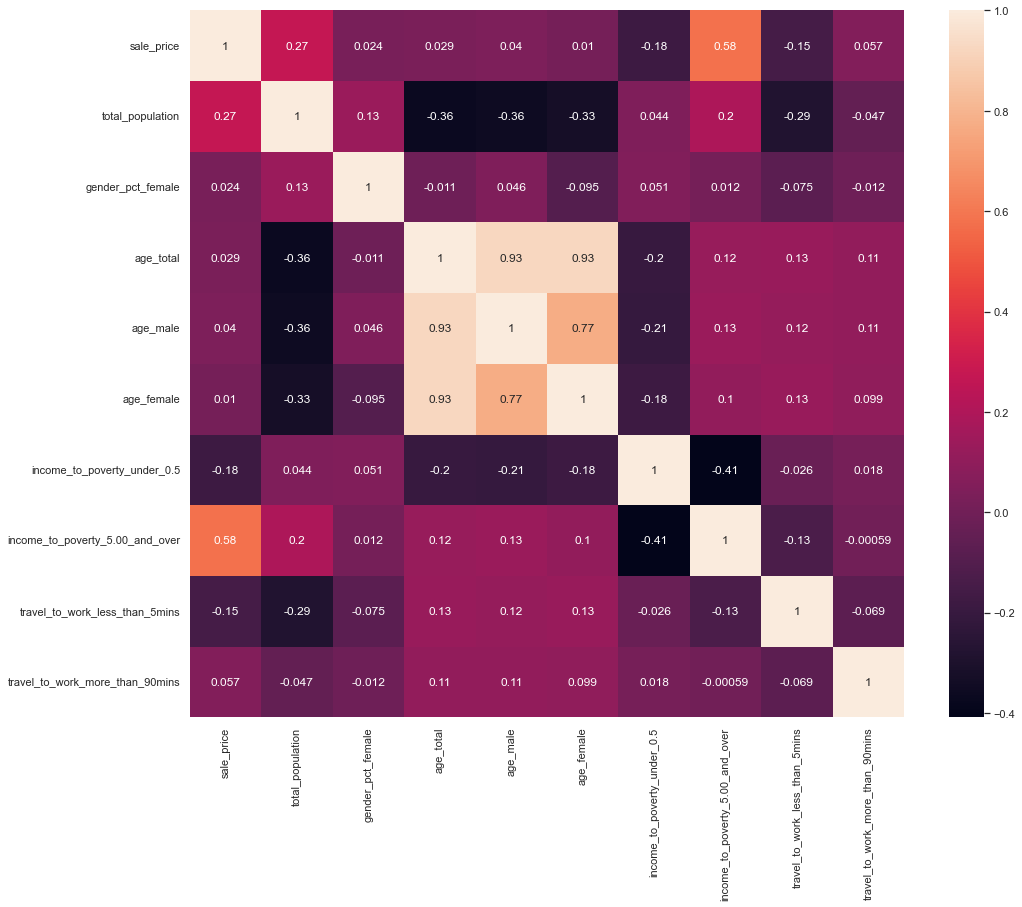

In [57]:
sns.heatmap(corr_housing_census_df.corr(), annot=True);

In [58]:
corr1_housing_census_df = filtered_zillow_df.drop(['zipcode','year','gender_pct_male'],axis=1)

In [59]:
sns.set(rc={'figure.figsize':(100, 100)})

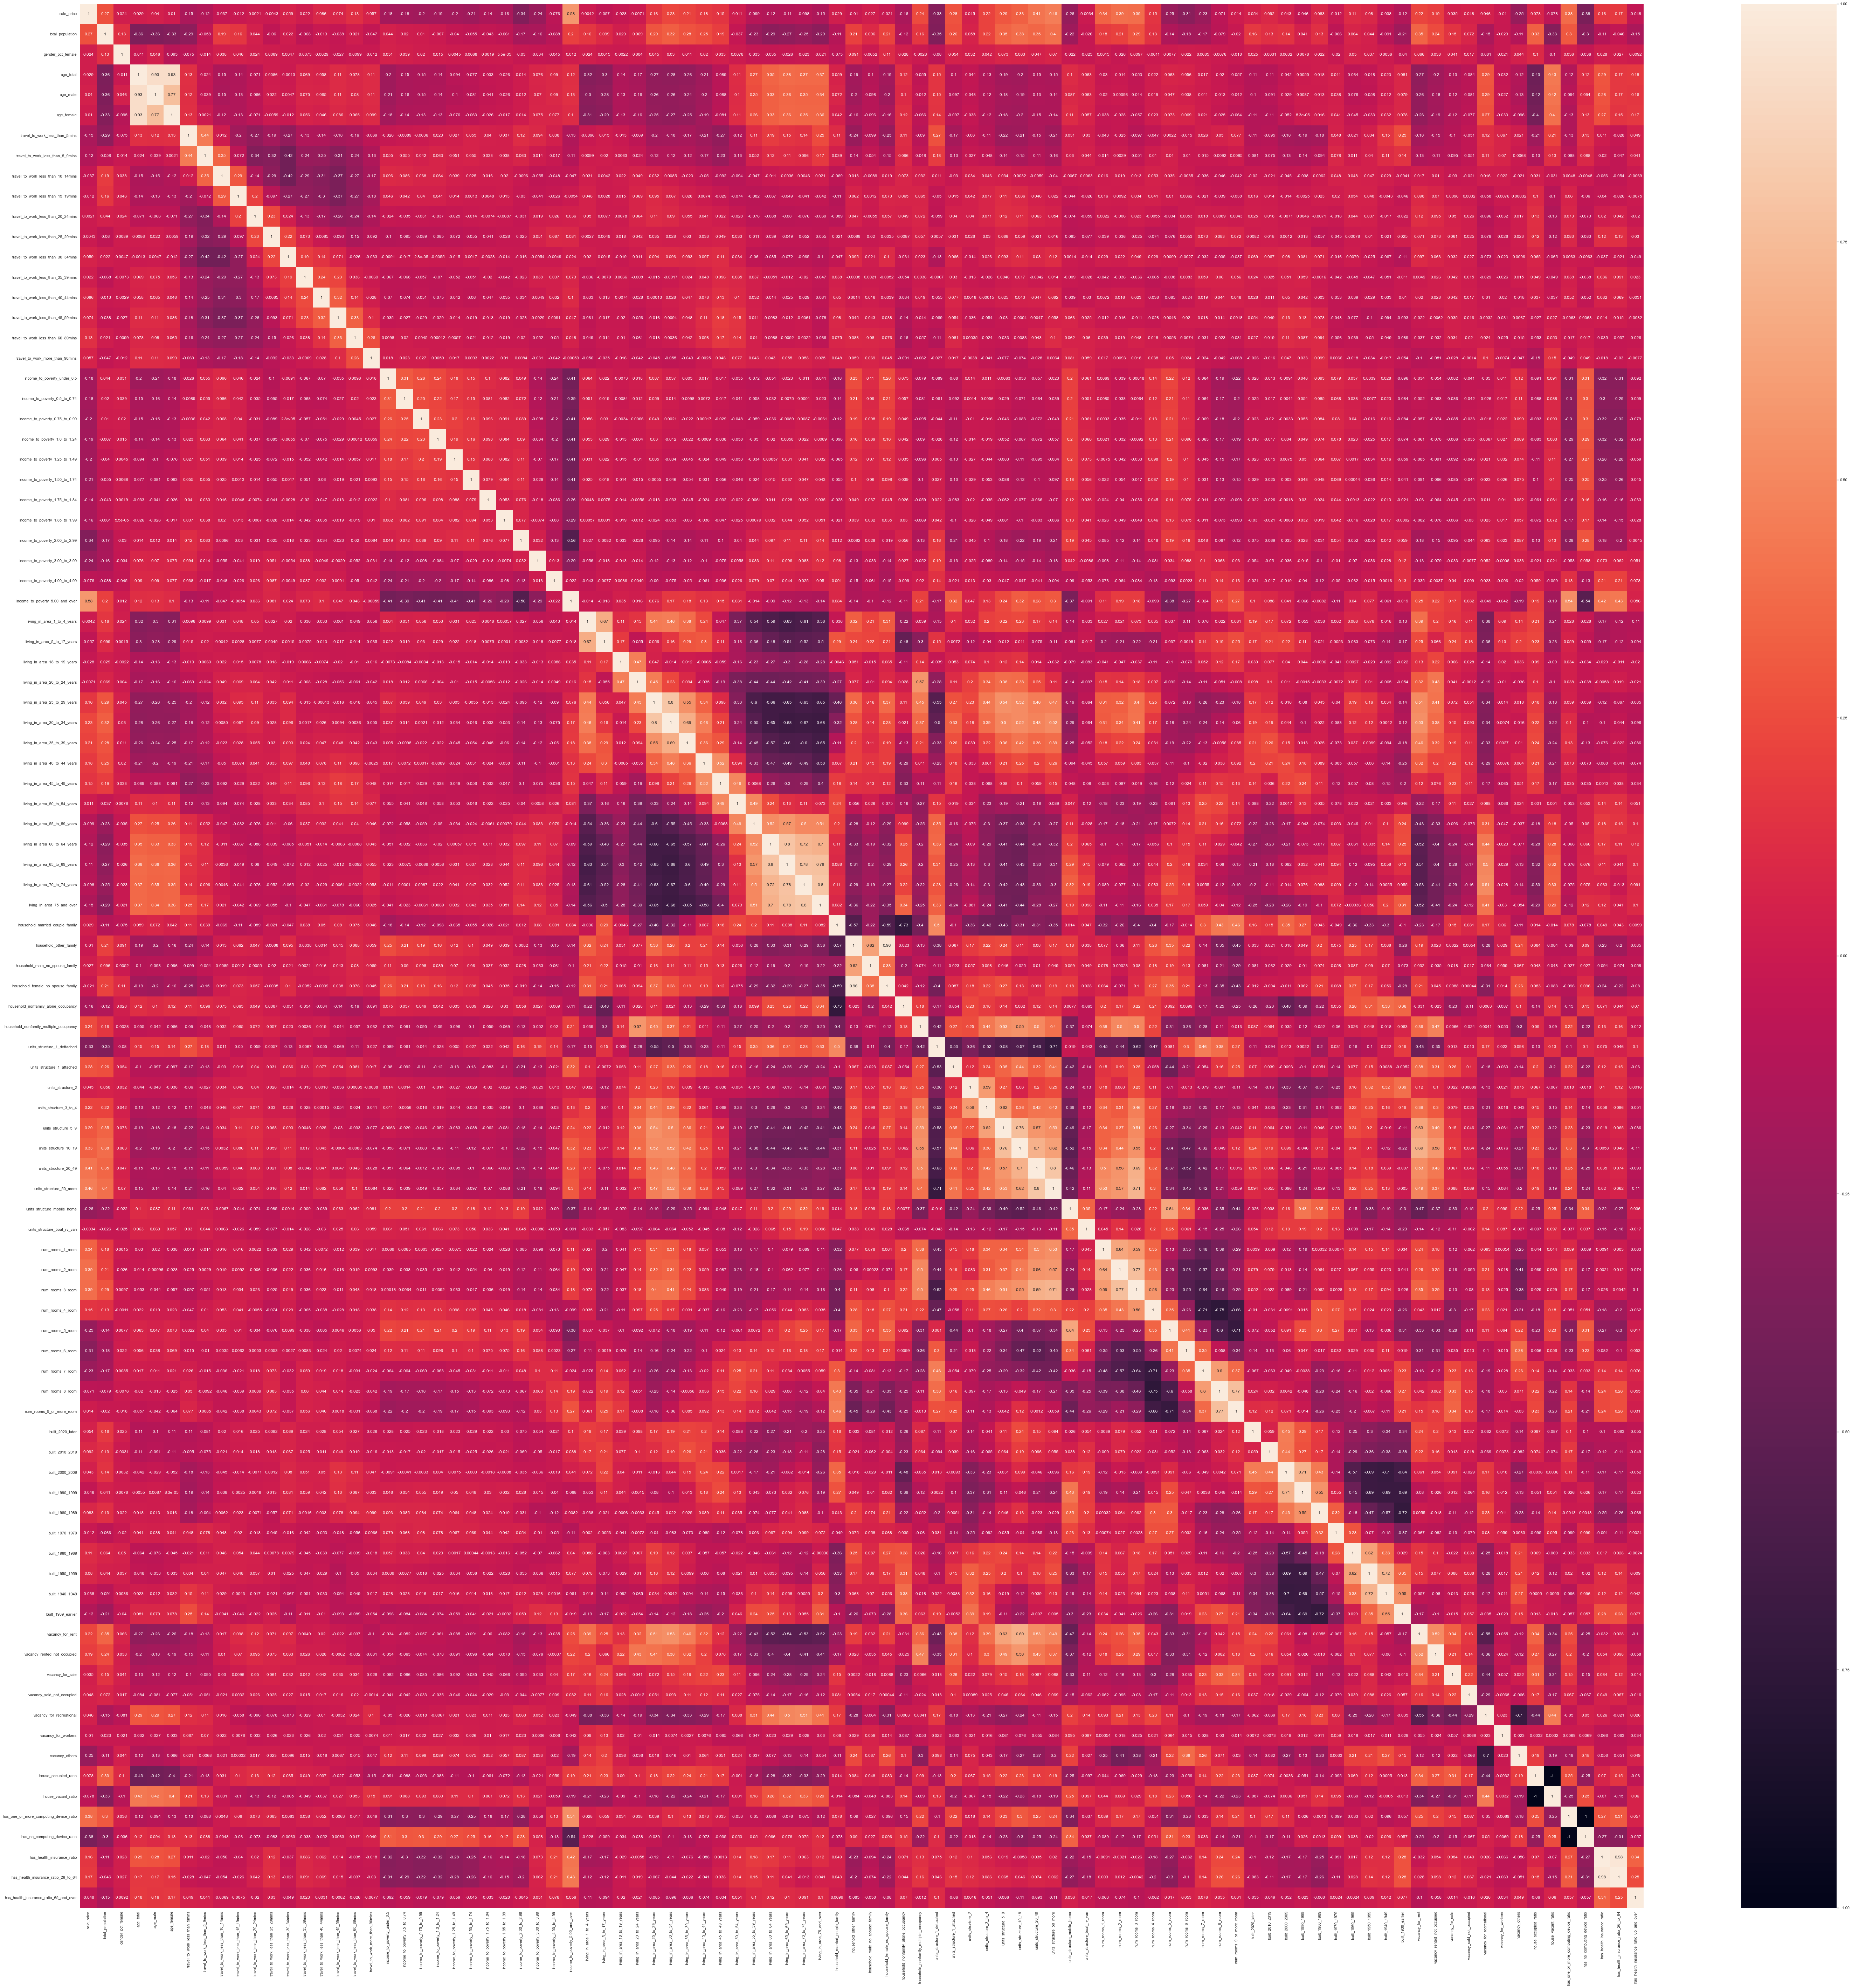

In [60]:
sns.heatmap(corr1_housing_census_df.corr(), annot=True);

In [61]:
# Scatter Plot

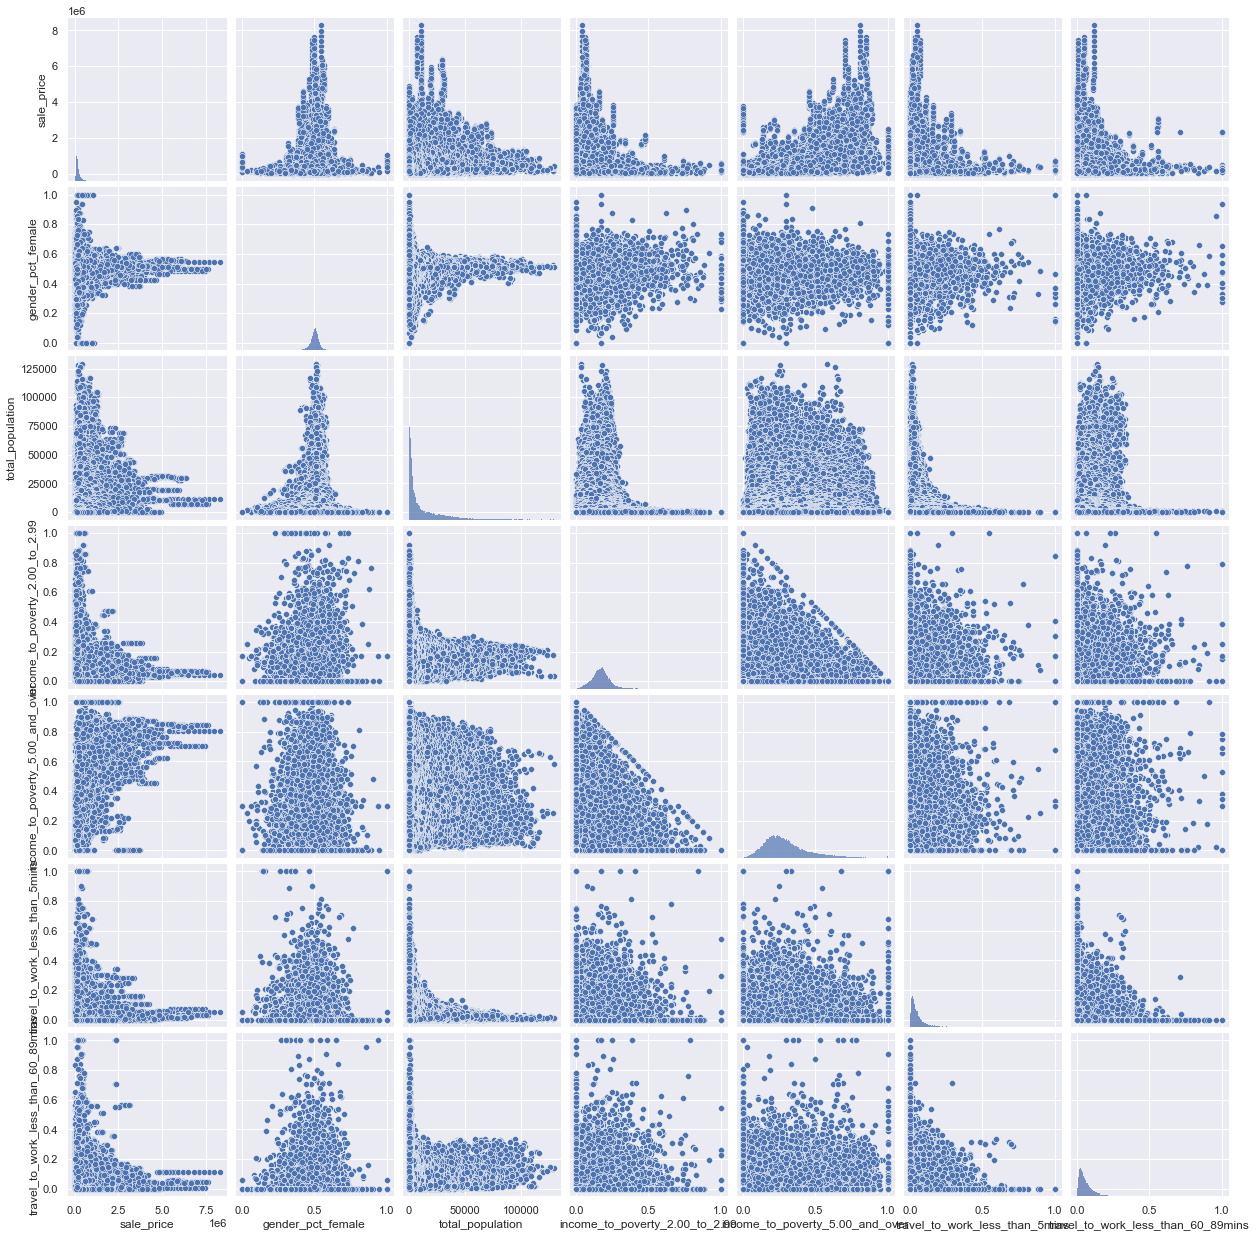

In [62]:
#scatterplot
sns.set()
cols = ['sale_price', 'gender_pct_female', 'total_population', 'income_to_poverty_2.00_to_2.99', 'income_to_poverty_5.00_and_over',\
        'travel_to_work_less_than_5mins', 'travel_to_work_less_than_60_89mins']
sns.pairplot(filtered_zillow_df[cols], size = 2.5)
plt.show();

In [64]:
#len(clustering_zillow_df.columns)

# <font color='blue'> Unsupervised learning </font>

In [65]:
clustering_zillow_df = enriched_housing_df[enriched_housing_df['date']==max(enriched_housing_df['date'])][census_columns_to_include]
# calculate the mean of each column
mean = clustering_zillow_df.mean()

# fill NaN values with the mean of each column
clustering_zillow_df.fillna(mean, inplace=True)
# clustering_zillow_df.replace([np.inf, -np.inf], 0, inplace=True)

In [66]:
scaler = MinMaxScaler()

clustering_zillow_scaled = scaler.fit_transform(clustering_zillow_df)

In [67]:
clustering_zillow_df = pd.DataFrame(clustering_zillow_scaled, columns=clustering_zillow_df.columns)

In [68]:
clustering_zillow_df.tail(5)

sale_price  total_population  gender_pct_male  gender_pct_female  \
35164    0.033783          0.002601         0.375000           0.625000   
35165    0.016456          0.003430         0.483070           0.516930   
35166    0.016456          0.003430         0.483070           0.516930   
35167    0.008859          0.006124         0.487990           0.512010   
35168    0.017961          0.004096         0.504726           0.495274   

       age_total  age_male  age_female  travel_to_work_less_than_5mins  \
35164   0.260026  0.353448    0.050060                        0.000000   
35165   0.460543  0.407635    0.476758                        0.009259   
35166   0.460543  0.407635    0.476758                        0.009259   
35167   0.662354  0.747537    0.609058                        0.000000   
35168   0.377749  0.376847    0.432658                        0.055085   

       travel_to_work_less_than_5_9mins  travel_to_work_less_than_10_14mins  \
35164                          0.000000                            0.000000   
35165                          0.000000                            0.074074   
35166                          0.000000                            0.074074   
35167                          0.057279                            0.410501   
35168                          0.114407                            0.072034   

       travel_to_work_less_than_15_19mins  travel_to_work_less_than_20_24mins  \
35164                            0.000000                            0.359155   
35165                            0.212963                            0.171296   
35166                            0.212963                            0.171296   
35167                            0.062053                            0.202864   
35168                            0.067797                            0.097458   

       travel_to_work_less_than_25_29mins  travel_to_work_less_than_30_34mins  \
35164                            0.000000                            0.000000   
35165                            0.194444                            0.199074   
35166                            0.194444                            0.199074   
35167                            0.133652                            0.000000   
35168                            0.152542                            0.262712   

       travel_to_work_less_than_35_39mins  travel_to_work_less_than_40_44mins  \
35164                            0.000000                            0.000000   
35165                            0.036376                            0.013889   
35166                            0.036376                            0.013889   
35167                            0.000000                            0.000000   
35168                            0.105428                            0.050847   

       travel_to_work_less_than_45_59mins  travel_to_work_less_than_60_89mins  \
35164                            0.211268                            0.000000   
35165                            0.074074                            0.004630   
35166                            0.074074                            0.004630   
35167                            0.133652                            0.000000   
35168                            0.012712                            0.029661   

       travel_to_work_more_than_90mins  income_to_poverty_under_0.5  \
35164                         0.429577                     0.000000   
35165                         0.018519                     0.022222   
35166                         0.018519                     0.022222   
35167                         0.000000                     0.000000   
35168                         0.004237                     0.066667   

       income_to_poverty_0.5_to_0.74  income_to_poverty_0.75_to_0.99  \
35164                       0.000000                        0.000000   
35165                       0.000000                        0.340741   
35166                       0.000000         

In [69]:
clustering_zillow_df.describe()

sale_price  total_population  gender_pct_male  gender_pct_female  \
count  35169.000000      35169.000000     35169.000000       35169.000000   
mean       0.031554          0.092459         0.501794           0.498206   
std        0.033957          0.118395         0.042769           0.042769   
min        0.000000          0.000000         0.000000           0.000000   
25%        0.015436          0.013340         0.480563           0.481307   
50%        0.022866          0.038215         0.498240           0.501760   
75%        0.035998          0.131243         0.518693           0.519437   
max        1.000000          1.000000         1.000000           1.000000   

          age_total      age_male    age_female  \
count  35169.000000  35169.000000  35169.000000   
mean       0.420468      0.464206      0.441478   
std        0.096757      0.097811      0.093883   
min        0.000000      0.000000      0.000000   
25%        0.357050      0.401478      0.380215   
50%        0.408797      0.451970      0.433850   
75%        0.472186      0.516010      0.495828   
max        1.000000      1.000000      1.000000   

       travel_to_work_less_than_5mins  travel_to_work_less_than_5_9mins  \
count                    35169.000000                      35169.000000   
mean                         0.050545                          0.104379   
std                          0.057084                          0.079854   
min                          0.000000                          0.000000   
25%                          0.014731                          0.050139   
50%                          0.032659                          0.086321   
75%                          0.065728                          0.139990   
max                          1.000000                          1.000000   

       travel_to_work_less_than_10_14mins  travel_to_work_less_than_15_19mins  \
count                        35169.000000                        35169.000000   
mean                             0.116891                            0.135552   
std                              0.071682                            0.073532   
min                              0.000000                            0.000000   
25%                              0.067516                            0.084967   
50%                              0.107519                            0.127619   
75%                              0.155429                            0.177855   
max                              1.000000                            1.000000   

       travel_to_work_less_than_20_24mins  travel_to_work_less_than_25_29mins  \
count                        35169.000000                        35169.000000   
mean                             0.136343                            0.069852   
std                              0.073404                            0.051065   
min                              0.000000                            0.000000   
25%                              0.086813                            0.036500   
50%                              0.130263                            0.062556   
75%                              0.176849                            0.091989   
max                              1.000000                            1.000000   

       travel_to_work_less_than_30_34mins  travel_to_work_less_than_35_39mins  \
count                        35169.000000                        35169.000000   
mean                             0.134301                            0.045692   
std                              0.074177                            0.045867   
min                              0.000000                            0.000000   
25%                              0.084110                            0.016401   
50%                              0.127517                            0.036326   
75%                              0.173741                            0.061780   
max                              1.000000                            1.

### <font color='blue'> Optimal number of clusters </font>

In [70]:
#cols = ['sale_price','total_population','gender_pct_male','gender_pct_female','age_total','age_male','age_female','income_to_poverty_5.00_and_over','living_in_area_1_to_4_years','living_in_area_5_to_17_years','living_in_area_18_to_19_years','living_in_area_20_to_24_years','living_in_area_25_to_29_years','living_in_area_30_to_34_years','living_in_area_35_to_39_years','living_in_area_40_to_44_years','living_in_area_45_to_49_years','living_in_area_50_to_54_years','living_in_area_55_to_59_years','living_in_area_60_to_64_years','living_in_area_65_to_69_years','living_in_area_70_to_74_years','living_in_area_75_and_over','household_married_couple_family','household_other_family','household_male_no_spouse_family','household_female_no_spouse_family','household_nonfamily_alone_occupancy','household_nonfamily_multiple_occupancy','units_structure_1_dettached','units_structure_1_attached','units_structure_2','units_structure_3_to_4','units_structure_5_9','units_structure_10_19','units_structure_20_49','units_structure_50_more','units_structure_mobile_home','units_structure_boat_rv_van','num_rooms_1_room','num_rooms_2_room','num_rooms_3_room','num_rooms_4_room','num_rooms_5_room','num_rooms_6_room','num_rooms_7_room','num_rooms_8_room','num_rooms_9_or_more_room','built_2020_later','built_2010_2019','built_2000_2009','built_1990_1999','built_1980_1989','built_1970_1979','built_1960_1969','built_1950_1959','built_1940_1949','built_1939_earlier','vacancy_for_rent','vacancy_rented_not_occupied','vacancy_for_sale','vacancy_sold_not_occupied','vacancy_for_recreational','vacancy_for_workers','vacancy_others','household_size_avg_owner_occupied','household_size_avg_renter_occupied']

In [72]:
import numpy as np
clustering_zillow_df = clustering_zillow_df[np.isfinite(clustering_zillow_df).all(1)]

<AxesSubplot:>

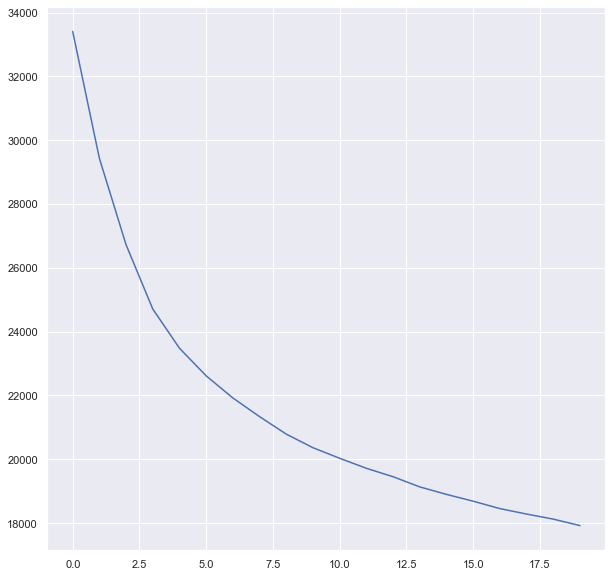

In [74]:
from sklearn.cluster import KMeans
score = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(clustering_zillow_df)
    score.append(kmeans.inertia_)
sns.set(rc={'figure.figsize':(10, 10)})
sns.lineplot(data=score)

### <font color='blue'> Select the correct number of clusters </font>

In [75]:
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(clustering_zillow_df)
labels_clusters_10 = kmeans.labels_

In [76]:
kmeans = KMeans(n_clusters=5,random_state=0)
kmeans.fit(clustering_zillow_df)
labels_clusters_5 = kmeans.labels_

### <font color='blue'> Evaluate the performance of the model output </font>

In [77]:
from sklearn.metrics import silhouette_score

# calculate the Silhouette Coefficient
score = silhouette_score(clustering_zillow_df, labels_clusters_10)

print("Silhouette Coefficient:", score)

Silhouette Coefficient: 0.0923785468486752


In [78]:
from sklearn.metrics import silhouette_score

# calculate the Silhouette Coefficient
score = silhouette_score(clustering_zillow_df, labels_clusters_5)

print("Silhouette Coefficient:", score)

Silhouette Coefficient: 0.11616469956917701


### <font color='blue'> PCA analysis </font>

In [292]:
from sklearn.decomposition import PCA

# creating the PCA instance
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(clustering_zillow_df)

# load the pca components into a df
PCA_components = pd.DataFrame(principalComponents)

<AxesSubplot:>

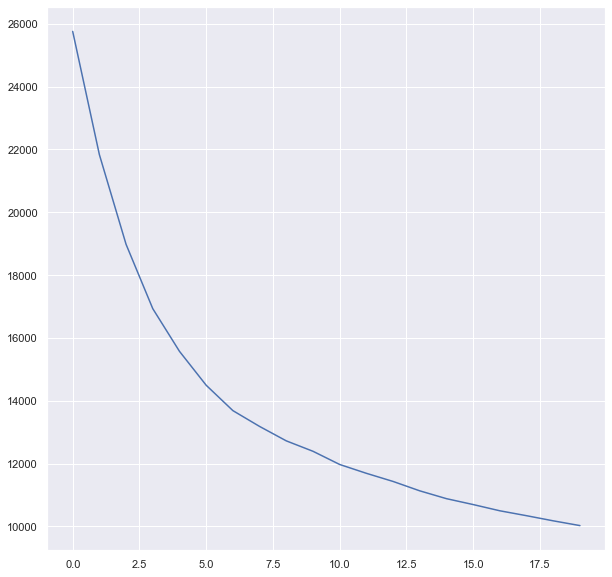

In [293]:
from sklearn.cluster import KMeans
score = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(PCA_components)
    score.append(kmeans.inertia_)
sns.set(rc={'figure.figsize':(10, 10)})
sns.lineplot(data=score)

In [294]:
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(PCA_components)
labels_clusters_10 = kmeans.labels_

In [295]:
from sklearn.metrics import silhouette_score

# calculate the Silhouette Coefficient
score = silhouette_score(clustering_zillow_df, labels_clusters_10)

print("Silhouette Coefficient:", score)

Silhouette Coefficient: 0.1071334806955259


In [298]:
correlated_features = ['total_population', 'income_to_poverty_2.00_to_2.99','income_to_poverty_3.00_to_3.99',\
                       'income_to_poverty_5.00_and_over','household_nonfamily_multiple_occupancy', 'units_structure_1_dettached',\
                       'units_structure_1_attached', 'units_structure_2','units_structure_3_to_4','units_structure_5_9',\
                       'units_structure_10_19','units_structure_20_49','units_structure_50_more','units_structure_mobile_home', \
                       'num_rooms_1_room','num_rooms_2_room','num_rooms_3_room','num_rooms_5_room','num_rooms_6_room','num_rooms_7_room', \
                       'vacancy_others','vacancy_for_rent','sale_price']

<AxesSubplot:>

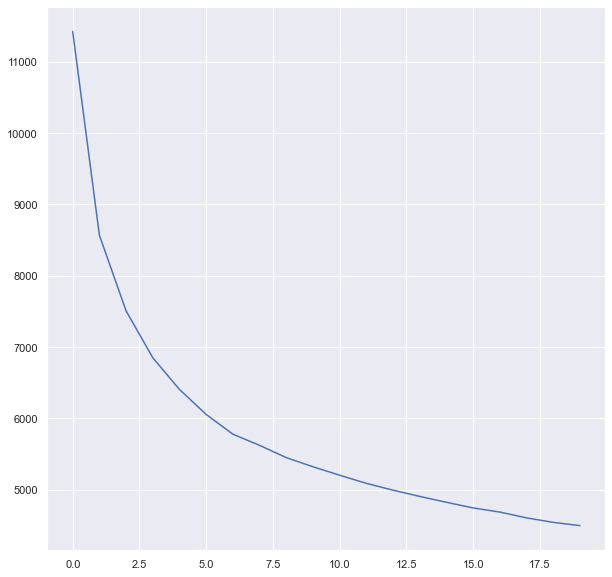

In [299]:
from sklearn.cluster import KMeans
score = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(clustering_zillow_df[correlated_features])
    score.append(kmeans.inertia_)
sns.set(rc={'figure.figsize':(10, 10)})
sns.lineplot(data=score)

In [302]:
kmeans = KMeans(n_clusters=20,random_state=0)
kmeans.fit(clustering_zillow_df[correlated_features])
labels_clusters_10 = kmeans.labels_

In [305]:
from sklearn.metrics import silhouette_score
from sklearn import metrics

# calculate the Silhouette Coefficient
score = silhouette_score(clustering_zillow_df, labels_clusters_10)

print("Silhouette Coefficient:", score)

Silhouette Coefficient: 0.03723824436515716


In [306]:
print(metrics.calinski_harabasz_score(clustering_zillow_df, labels_clusters_10))

1259.4148103948057
